In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [52]:
def read_and_parse_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    jobs = []
    changeover_costs = []
    reading_jobs = False
    reading_changeover = False

    for line in lines:
        line = line.strip().replace(',', ' ')
        if line == "@jobs":
            reading_jobs = True
            reading_changeover = False
            continue
        elif line == "@changeover":
            reading_jobs = False
            reading_changeover = True
            continue
        
        if reading_jobs:
            if line != "0 0":  # Skip the reference point
                try:
                    job = tuple(map(int, line.split()))
                    if len(job) == 2:
                        jobs.append(job)
                    else:
                        print(f"Skipping invalid job line: {line}")
                except ValueError:
                    print(f"Skipping invalid job line: {line}")
        elif reading_changeover:
            try:
                changeover_costs.append(list(map(int, line.split())))
            except ValueError:
                print(f"Skipping invalid changeover line: {line}")
    
    return jobs, changeover_costs

# Read the dataset
jobs_100_new, changeover_100_new = read_and_parse_dataset('SMTTCC1problem')
jobs_50_new, changeover_50_new = read_and_parse_dataset('SMTTCC2problem')

# Check the structure of the jobs list
print("Jobs (100):", jobs_100_new[:5])
print("Jobs (50):", jobs_50_new[:5])

# Check the changeover costs
print("Changeover Costs (100):", changeover_100_new[:5])
print("Changeover Costs (50):", changeover_50_new[:5])


Skipping invalid job line: 
Skipping invalid job line: 
Jobs (100): [(22, 72), (111, 67), (180, 94), (187, 13), (165, 68)]
Jobs (50): [(48, 67), (46, 57), (86, 63), (94, 30), (116, 85)]
Changeover Costs (100): [[0, 12, 15, 95, 21, 42, 74, 74, 32, 42, 87, 63, 69, 29, 7, 27, 43, 14, 12, 14, 17, 1, 79, 36, 20, 51, 6, 8, 49, 14, 83, 12, 26, 16, 97, 82, 46, 76, 69, 95, 39, 88, 59, 95, 49, 72, 44, 65, 56, 64, 36, 48, 13, 86, 77, 69, 16, 40, 24, 39, 42, 80, 71, 72, 48, 42, 27, 1, 95, 71, 61, 73, 51, 25, 15, 15, 98, 70, 11, 67, 65, 78, 78, 36, 69, 99, 82, 2, 11, 93, 88, 84, 84, 78, 42, 59, 45, 18, 60, 87, 91], [94, 0, 58, 54, 66, 84, 90, 93, 6, 31, 89, 64, 26, 43, 9, 41, 22, 24, 35, 6, 4, 17, 47, 38, 62, 2, 92, 57, 41, 9, 62, 45, 2, 42, 77, 56, 23, 87, 49, 18, 7, 61, 67, 34, 66, 59, 12, 3, 15, 37, 11, 41, 85, 37, 26, 16, 61, 2, 14, 58, 64, 58, 92, 57, 4, 82, 14, 17, 4, 36, 24, 52, 96, 37, 46, 21, 19, 26, 57, 3, 90, 60, 78, 35, 33, 34, 36, 34, 28, 97, 9, 52, 64, 16, 30, 38, 47, 25, 78, 62, 9], 

In [53]:
import random
import numpy as np

# Define the initial population
def generate_initial_population(jobs, population_size):
    population = []
    for _ in range(population_size):
        individual = list(range(len(jobs)))
        random.shuffle(individual)
        population.append(individual)
    return population

# Calculate fitness
def calculate_fitness(schedule, jobs, changeover_costs):
    total_tardiness = 0
    total_changeover_cost = 0
    current_time = 0

    for i in range(len(schedule)):
        job_id = schedule[i]
        due_date, processing_time = jobs[job_id]
        current_time += processing_time
        tardiness = max(0, current_time - due_date)
        total_tardiness += tardiness
        
        if i == 0:
            total_changeover_cost += changeover_costs[0][job_id + 1]
        else:
            previous_job_id = schedule[i - 1]
            total_changeover_cost += changeover_costs[previous_job_id + 1][job_id + 1]
    
    return total_tardiness, total_changeover_cost

# Selection
def pareto_dominates(a, b):
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

def selection(population, fitnesses, num_parents):
    selected = []
    for _ in range(num_parents):
        tournament = random.sample(list(zip(population, fitnesses)), k=3)
        tournament.sort(key=lambda x: x[1])
        selected.append(tournament[0][0])
    return selected

# Crossover
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child1 = [-1] * size
    child1[start:end+1] = parent1[start:end+1]
    fill_index = (end + 1) % size
    for gene in parent2:
        if gene not in child1:
            child1[fill_index] = gene
            fill_index = (fill_index + 1) % size
    return child1

# Mutation
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(individual)-1)
            individual[i], individual[j] = individual[j], individual[i]

# Genetic Algorithm
def genetic_algorithm(jobs, changeover_costs, population_size=100, generations=100, crossover_rate=0.8, mutation_rate=0.1):
    population = generate_initial_population(jobs, population_size)
    pareto_front = []

    for generation in range(generations):
        fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]

        # Debugging: Check fitnesses and population
        print(f"Generation {generation}: Fitnesses calculated")

        # Update Pareto front
        new_pareto_front = []
        for i in range(len(population)):
            fitness = fitnesses[i]
            dominated = False
            for pf in pareto_front:
                if pareto_dominates(pf, fitness):
                    dominated = True
                    break
            if not dominated:
                new_pareto_front = [pf for pf in new_pareto_front if not pareto_dominates(fitness, pf)]
                new_pareto_front.append(fitness)
        pareto_front = new_pareto_front

        # Debugging: Check Pareto front
        print(f"Generation {generation}: Pareto front updated with {len(pareto_front)} solutions")

        new_population = []

        while len(new_population) < population_size:
            parents = selection(population, fitnesses, 2)
            if random.random() < crossover_rate:
                offspring = crossover(parents[0], parents[1])
            else:
                offspring = parents[0]
            
            mutate(offspring, mutation_rate)
            new_population.append(offspring)
        
        population = new_population[:population_size]
    
    return pareto_front

# Run GA on both datasets
pareto_front_100 = genetic_algorithm(jobs_100_new, changeover_100_new)
pareto_front_50 = genetic_algorithm(jobs_50_new, changeover_50_new)

# Display the Pareto fronts
import pandas as pd
pareto_front_100_df = pd.DataFrame(pareto_front_100, columns=['Total Tardiness', 'Changeover Cost'])
pareto_front_50_df = pd.DataFrame(pareto_front_50, columns=['Total Tardiness', 'Changeover Cost'])



pareto_front_100_df.head(), pareto_front_50_df.head()


Generation 0: Fitnesses calculated
Generation 0: Pareto front updated with 20 solutions
Generation 1: Fitnesses calculated
Generation 1: Pareto front updated with 3 solutions
Generation 2: Fitnesses calculated
Generation 2: Pareto front updated with 2 solutions
Generation 3: Fitnesses calculated
Generation 3: Pareto front updated with 6 solutions
Generation 4: Fitnesses calculated
Generation 4: Pareto front updated with 5 solutions
Generation 5: Fitnesses calculated
Generation 5: Pareto front updated with 7 solutions
Generation 6: Fitnesses calculated
Generation 6: Pareto front updated with 3 solutions
Generation 7: Fitnesses calculated
Generation 7: Pareto front updated with 7 solutions
Generation 8: Fitnesses calculated
Generation 8: Pareto front updated with 7 solutions
Generation 9: Fitnesses calculated
Generation 9: Pareto front updated with 0 solutions
Generation 10: Fitnesses calculated
Generation 10: Pareto front updated with 14 solutions
Generation 11: Fitnesses calculated
Gen

(   Total Tardiness  Changeover Cost
 0           121219             4492
 1           123021             4782
 2           127277             4555
 3           123021             4782
 4           121549             5055,
    Total Tardiness  Changeover Cost
 0            28017             2661
 1            28397             2203
 2            28017             2661
 3            29376             2417)

Import libraries 

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd


Define GA Components

Represent Solutions

In [30]:
def generate_initial_population(pop_size, num_jobs):
    population = []
    for _ in range(pop_size):
        individual = list(np.random.permutation(num_jobs))
        population.append(individual)
    return population


Fitness Function

In [39]:
def calculate_fitness(individual, due_dates, processing_times, changeover_costs):
    total_tardiness = 0
    total_changeover_cost = 0
    completion_time = 0
    
    num_jobs = len(due_dates)
    
    for i in range(len(individual)):
        job = individual[i]
        completion_time += processing_times[job]
        total_tardiness += max(0, completion_time - due_dates[job])
        if i < len(individual) - 1:
            next_job = individual[i + 1]
            if job >= num_jobs or next_job >= num_jobs:
                print(f"Index error: job={job}, next_job={next_job}, num_jobs={num_jobs}")
            total_changeover_cost += changeover_costs[job][next_job]
    
    return total_tardiness, total_changeover_cost

# Re-run the algorithm with debugging information


Non-dominated sorting

In [54]:
# Display the Pareto fronts
import pandas as pd

# Pareto front for 100 jobs
pareto_front_100_df = pd.DataFrame(pareto_front_100, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 100 Jobs:")
print(pareto_front_100_df.head())

# Pareto front for 50 jobs
pareto_front_50_df = pd.DataFrame(pareto_front_50, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 50 Jobs:")
print(pareto_front_50_df.head())


Pareto Front for 100 Jobs:
   Total Tardiness  Changeover Cost
0           121219             4492
1           123021             4782
2           127277             4555
3           123021             4782
4           121549             5055
Pareto Front for 50 Jobs:
   Total Tardiness  Changeover Cost
0            28017             2661
1            28397             2203
2            28017             2661
3            29376             2417


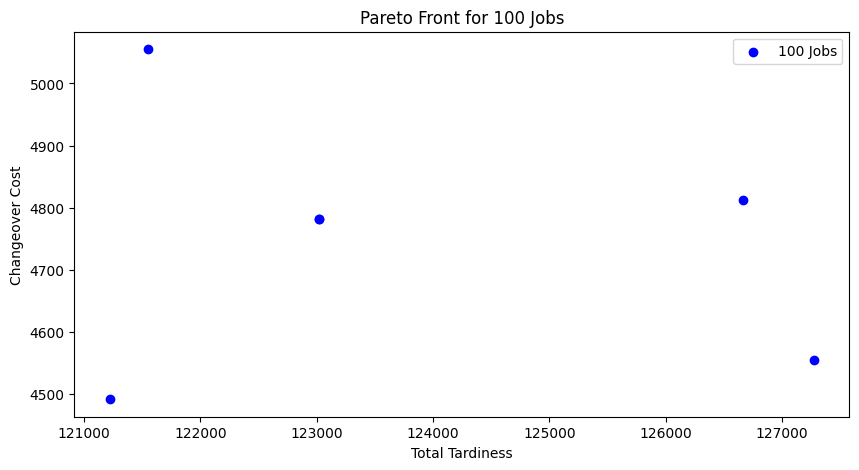

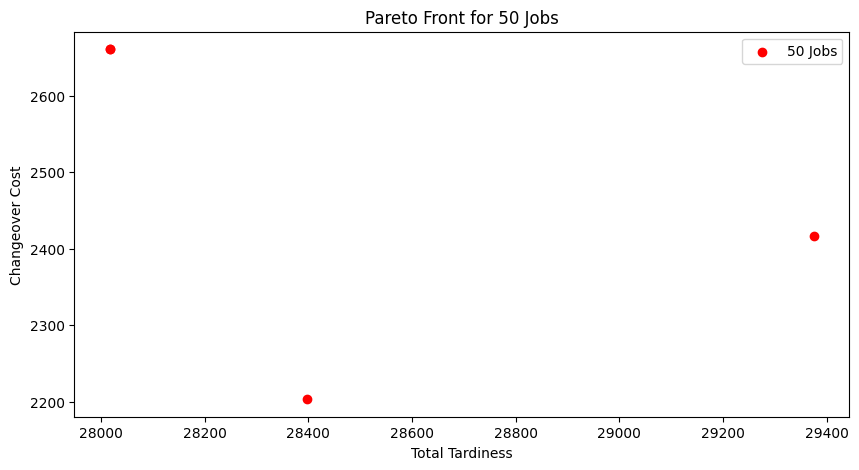

In [55]:
import matplotlib.pyplot as plt

# Plot Pareto Front for 100 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_100_df['Total Tardiness'], pareto_front_100_df['Changeover Cost'], c='blue', label='100 Jobs')
plt.title('Pareto Front for 100 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()

# Plot Pareto Front for 50 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_50_df['Total Tardiness'], pareto_front_50_df['Changeover Cost'], c='red', label='50 Jobs')
plt.title('Pareto Front for 50 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()


In [57]:
import random
import numpy as np

# Generate initial population
def generate_initial_population(jobs, population_size):
    population = []
    for _ in range(population_size):
        individual = list(range(len(jobs)))
        random.shuffle(individual)
        population.append(individual)
    return population

# Calculate fitness
def calculate_fitness(schedule, jobs, changeover_costs):
    total_tardiness = 0
    total_changeover_cost = 0
    current_time = 0

    for i in range(len(schedule)):
        job_id = schedule[i]
        due_date, processing_time = jobs[job_id]
        current_time += processing_time
        tardiness = max(0, current_time - due_date)
        total_tardiness += tardiness
        
        if i == 0:
            total_changeover_cost += changeover_costs[0][job_id + 1]
        else:
            previous_job_id = schedule[i - 1]
            total_changeover_cost += changeover_costs[previous_job_id + 1][job_id + 1]
    
    return total_tardiness, total_changeover_cost

# Pareto dominance check
def pareto_dominates(a, b):
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

# Crossover
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child1 = [-1] * size
    child1[start:end+1] = parent1[start:end+1]
    fill_index = (end + 1) % size
    for gene in parent2:
        if gene not in child1:
            child1[fill_index] = gene
            fill_index = (fill_index + 1) % size
    return child1

# Mutation
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(individual)-1)
            individual[i], individual[j] = individual[j], individual[i]

# Non-dominated sorting
def non_dominated_sorting(population, fitnesses):
    S = [[] for _ in range(len(population))]
    front = [[]]
    n = [0] * len(population)
    rank = [0] * len(population)

    for p in range(len(population)):
        S[p] = []
        n[p] = 0
        for q in range(len(population)):
            if pareto_dominates(fitnesses[p], fitnesses[q]):
                S[p].append(q)
            elif pareto_dominates(fitnesses[q], fitnesses[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while len(front[i]) > 0:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    front.pop(-1)
    return front

# Crowding distance calculation
def calculate_crowding_distance(fitnesses, front):
    distance = [0] * len(fitnesses)
    for i in range(len(fitnesses[0])):
        sorted_fitnesses = sorted(enumerate(fitnesses), key=lambda x: x[1][i])
        distance[sorted_fitnesses[0][0]] = float('inf')
        distance[sorted_fitnesses[-1][0]] = float('inf')
        for j in range(1, len(sorted_fitnesses) - 1):
            distance[sorted_fitnesses[j][0]] += (sorted_fitnesses[j+1][1][i] - sorted_fitnesses[j-1][1][i]) / (max(fitnesses, key=lambda x: x[i])[i] - min(fitnesses, key=lambda x: x[i])[i])
    return distance

# NSGA-II algorithm
def nsga_ii(jobs, changeover_costs, population_size=100, generations=100, crossover_rate=0.8, mutation_rate=0.1):
    population = generate_initial_population(jobs, population_size)
    
    # Debugging: Check initial population structure
    print(f"Initial population: {population[:2]}")  # Print first two individuals to verify structure
    
    for generation in range(generations):
        # Calculate fitness for each individual
        fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
        
        # Debugging: Check fitnesses
        print(f"Generation {generation} fitnesses: {fitnesses[:2]}")  # Print fitnesses of first two individuals
        
        # Non-dominated sorting
        fronts = non_dominated_sorting(population, fitnesses)
        
        # Calculate crowding distance
        distances = calculate_crowding_distance(fitnesses, fronts)
        
        new_population = []
        for i, front in enumerate(fronts):
            if len(new_population) + len(front) > population_size:
                break
            new_population.extend(front)
        remaining = population_size - len(new_population)
        if remaining > 0:
            sorted_front = sorted(fronts[i], key=lambda x: distances[x], reverse=True)
            new_population.extend(sorted_front[:remaining])
        
        # Generate offspring
        offspring_population = []
        while len(offspring_population) < population_size:
            parents = random.sample(new_population, 2)
            if random.random() < crossover_rate:
                offspring = crossover(population[parents[0]], population[parents[1]])
            else:
                offspring = population[parents[0]]
            mutate(offspring, mutation_rate)
            offspring_population.append(offspring)
        
        population = new_population + offspring_population
    
    fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
    pareto_front = non_dominated_sorting(population, fitnesses)[0]
    return [fitnesses[i] for i in pareto_front]

# Read and parse datasets
def read_and_parse_dataset(file_path):
    with open(file_path, 'r') as file):
        lines = file.readlines()
    
    jobs = []
    changeover_costs = []
    reading_jobs = False
    reading_changeover = False

    for line in lines:
        line = line.strip().replace(',', ' ')
        if line == "@jobs":
            reading_jobs = True
            reading_changeover = False
            continue
        elif line == "@changeover":
            reading_jobs = False
            reading_changeover = True
            continue
        
        if reading_jobs:
            if line != "0 0":  # Skip the reference point
                try:
                    job = tuple(map(int, line.split()))
                    if len(job) == 2:
                        jobs.append(job)
                    else:
                        print(f"Skipping invalid job line: {line}")
                except ValueError:
                    print(f"Skipping invalid job line: {line}")
        elif reading_changeover:
            try:
                changeover_costs.append(list(map(int, line.split())))
            except ValueError:
                print(f"Skipping invalid changeover line: {line}")
    
    return jobs, changeover_costs

# Read datasets
jobs_100_new, changeover_100_new = read_and_parse_dataset('/mnt/data/SMTTCC1problem')
jobs_50_new, changeover_50_new = read_and_parse_dataset('/mnt/data/SMTTCC2problem')

# Run NSGA-II on both datasets
pareto_front_100 = nsga_ii(jobs_100_new, changeover_100_new)
pareto_front_50 = nsga_ii(jobs_50_new, changeover_50_new)

# Display the Pareto fronts
import pandas as pd

# Pareto front for 100 jobs
pareto_front_100_df = pd.DataFrame(pareto_front_100, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 100 Jobs:")
print(pareto_front_100_df.head())

# Pareto front for 50 jobs
pareto_front_50_df = pd.DataFrame(pareto_front_50, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 50 Jobs:")
print(pareto_front_50_df.head())

# Visualize the Pareto fronts
import matplotlib.pyplot as plt

# Plot Pareto Front for 100 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_100_df['Total Tardiness'], pareto_front_100_df['Changeover Cost'], c='blue', label='100 Jobs')


SyntaxError: unmatched ')' (411304177.py, line 151)

Crowding distance

In [34]:
def calculate_crowding_distance(front, fitnesses):
    distance = [0] * len(front)
    for m in range(len(fitnesses[0])):
        front.sort(key=lambda x: fitnesses[x][m])
        distance[front[0]] = distance[front[-1]] = float('inf')
        for i in range(1, len(front) - 1):
            distance[front[i]] += (fitnesses[front[i + 1]][m] - fitnesses[front[i - 1]][m]) / (max(fitnesses, key=lambda x: x[m])[m] - min(fitnesses, key=lambda x: x[m])[m])
    return distance


Crossover and Mutation

In [35]:
def order_crossover(parent1, parent2):
    size = len(parent1)
    child1, child2 = [-1]*size, [-1]*size
    
    start, end = sorted([random.randint(0, size - 1) for _ in range(2)])
    
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]
    
    fill_child(child1, parent2, start, end)
    fill_child(child2, parent1, start, end)
    
    return child1, child2

def fill_child(child, parent, start, end):
    size = len(child)
    current_pos = end
    for i in range(end, end + size):
        pos = i % size
        if parent[pos] not in child:
            child[current_pos] = parent[pos]
            current_pos = (current_pos + 1) % size

def swap_mutation(individual):
    mutant = individual[:]
    idx1, idx2 = random.sample(range(len(individual)), 2)
    mutant[idx1], mutant[idx2] = mutant[idx2], mutant[idx1]
    return mutant


Selection Operator

In [36]:
def tournament_selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = min(tournament, key=lambda x: sum(x[1]))
        selected.append(winner[0])
    return selected


Main loop

In [70]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate initial population
def generate_initial_population(jobs, population_size):
    population = []
    for _ in range(population_size):
        individual = list(range(len(jobs)))
        random.shuffle(individual)
        population.append(individual)
    return population

# Calculate fitness
def calculate_fitness(schedule, jobs, changeover_costs):
    total_tardiness = 0
    total_changeover_cost = 0
    current_time = 0

    for i in range(len(schedule)):
        job_id = schedule[i]
        due_date, processing_time = jobs[job_id]
        current_time += processing_time
        tardiness = max(0, current_time - due_date)
        total_tardiness += tardiness
        
        if i == 0:
            total_changeover_cost += changeover_costs[0][job_id + 1]
        else:
            previous_job_id = schedule[i - 1]
            total_changeover_cost += changeover_costs[previous_job_id + 1][job_id + 1]
    
    return total_tardiness, total_changeover_cost

# Pareto dominance check
def pareto_dominates(a, b):
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

# Crossover
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child1 = [-1] * size
    child1[start:end+1] = parent1[start:end+1]
    fill_index = (end + 1) % size
    for gene in parent2:
        if gene not in child1:
            child1[fill_index] = gene
            fill_index = (fill_index + 1) % size
    return child1

# Mutation
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(individual)-1)
            individual[i], individual[j] = individual[j], individual[i]

# Non-dominated sorting
def non_dominated_sorting(population, fitnesses):
    S = [[] for _ in range(len(population))]
    front = [[]]
    n = [0] * len(population)
    rank = [0] * len(population)

    for p in range(len(population)):
        S[p] = []
        n[p] = 0
        for q in range(len(population)):
            if pareto_dominates(fitnesses[p], fitnesses[q]):
                S[p].append(q)
            elif pareto_dominates(fitnesses[q], fitnesses[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while len(front[i]) > 0:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    front.pop(-1)
    return front

# Crowding distance calculation
def calculate_crowding_distance(fitnesses, front):
    distance = [0] * len(fitnesses)
    for i in range(len(fitnesses[0])):
        sorted_fitnesses = sorted(enumerate(fitnesses), key=lambda x: x[1][i])
        distance[sorted_fitnesses[0][0]] = float('inf')
        distance[sorted_fitnesses[-1][0]] = float('inf')
        for j in range(1, len(sorted_fitnesses) - 1):
            distance[sorted_fitnesses[j][0]] += (sorted_fitnesses[j+1][1][i] - sorted_fitnesses[j-1][1][i]) / (max(fitnesses, key=lambda x: x[i])[i] - min(fitnesses, key=lambda x: x[i])[i])
    return distance

# NSGA-II algorithm
def nsga_ii(jobs, changeover_costs, population_size=100, generations=100, crossover_rate=0.8, mutation_rate=0.1):
    population = generate_initial_population(jobs, population_size)
    
    # Debugging: Check initial population structure
    print(f"Initial population: {population[:2]}")  # Print first two individuals to verify structure
    
    for generation in range(generations):
        # Calculate fitness for each individual
        fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
        
        # Debugging: Check fitnesses
        print(f"Generation {generation} fitnesses: {fitnesses[:2]}")  # Print fitnesses of first two individuals
        
        # Non-dominated sorting
        fronts = non_dominated_sorting(population, fitnesses)
        
        # Calculate crowding distance
        distances = calculate_crowding_distance(fitnesses, fronts)
        
        new_population = []
        for i, front in enumerate(fronts):
            if len(new_population) + len(front) > population_size:
                break
            new_population.extend(front)
        remaining = population_size - len(new_population)
        if remaining > 0:
            sorted_front = sorted(fronts[i], key=lambda x: distances[x], reverse=True)
            new_population.extend(sorted_front[:remaining])
        
        # Generate offspring
        offspring_population = []
        while len(offspring_population) < population_size:
            parents = random.sample(new_population, 2)
            if random.random() < crossover_rate:
                offspring = crossover(population[parents[0]], population[parents[1]])
            else:
                offspring = population[parents[0]][:]  # Copy the parent
            mutate(offspring, mutation_rate)
            offspring_population.append(offspring)
        
        population = new_population + offspring_population
        
        # Debugging: Check population structure after generation
        print(f"Generation {generation} population: {population[:2]}")  # Print first two individuals to verify structure
    
    fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
    pareto_front = non_dominated_sorting(population, fitnesses)[0]
    return [fitnesses[i] for i in pareto_front]

# Read and parse datasets
def read_and_parse_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    jobs = []
    changeover_costs = []
    reading_jobs = False
    reading_changeover = False

    for line in lines:
        line = line.strip().replace(',', ' ')
        if line == "@jobs":
            reading_jobs = True
            reading_changeover = False
            continue
        elif line == "@changeover":
            reading_jobs = False
            reading_changeover = True
            continue
        
        if reading_jobs:
            if line != "0 0":  # Skip the reference point
                try:
                    job = tuple(map(int, line.split()))
                    if len(job) == 2:
                        jobs.append(job)
                    else:
                        print(f"Skipping invalid job line: {line}")
                except ValueError:
                    print(f"Skipping invalid job line: {line}")
        elif reading_changeover:
            try:
                changeover_costs.append(list(map(int, line.split())))
            except ValueError:
                print(f"Skipping invalid changeover line: {line}")
    
    return jobs, changeover_costs

# Read datasets
jobs_100_new, changeover_100_new = read_and_parse_dataset('SMTTCC1problem')
jobs_50_new, changeover_50_new = read_and_parse_dataset('SMTTCC2problem')

# Run NSGA-II on both datasets
pareto_front_100 = nsga_ii(jobs_100_new, changeover_100_new)
pareto_front_50 = nsga_ii(jobs_50_new, changeover_50_new)

# Display the Pareto fronts

# Pareto front for 100 jobs
pareto_front_100_df = pd.DataFrame(pareto_front_100, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 100 Jobs:")
print(pareto_front_100_df.head())

# Pareto front for 50 jobs
pareto_front_50_df = pd.DataFrame(pareto_front_50, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 50 Jobs:")
print(pareto_front_50_df.head())

# Visualize the Pareto fronts


# Visualize the Pareto fronts

# Plot Pareto Front for 100 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_100_df['Total Tardiness'], pareto_front_100_df['Changeover Cost'], c='blue', label='100 Jobs')
plt.title('Pareto Front for 100 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()

# Plot Pareto Front for 50 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_50_df['Total Tardiness'], pareto_front_50_df['Changeover Cost'], c='red', label='50 Jobs')
plt.title('Pareto Front for 50 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()


Skipping invalid job line: 
Skipping invalid job line: 
Initial population: [[14, 79, 15, 82, 6, 11, 88, 62, 97, 51, 39, 81, 80, 22, 78, 89, 5, 72, 3, 54, 91, 36, 83, 42, 67, 13, 94, 49, 28, 55, 17, 98, 38, 10, 92, 8, 18, 56, 90, 53, 95, 40, 27, 57, 25, 85, 23, 50, 60, 77, 41, 69, 45, 61, 37, 31, 20, 87, 75, 43, 71, 26, 16, 84, 21, 63, 7, 24, 93, 65, 74, 99, 73, 46, 52, 68, 48, 34, 4, 12, 1, 33, 64, 32, 0, 86, 58, 19, 44, 30, 70, 66, 96, 35, 29, 59, 76, 47, 9, 2], [20, 56, 47, 78, 62, 1, 85, 59, 7, 77, 39, 65, 64, 6, 49, 42, 48, 93, 28, 32, 5, 91, 45, 24, 86, 83, 38, 36, 74, 9, 16, 90, 29, 94, 82, 52, 57, 89, 43, 99, 19, 13, 75, 12, 70, 40, 0, 17, 35, 92, 25, 67, 50, 11, 53, 97, 55, 26, 33, 34, 96, 46, 30, 41, 61, 79, 22, 23, 68, 3, 4, 54, 10, 60, 76, 14, 15, 58, 98, 31, 8, 88, 27, 71, 51, 95, 44, 72, 21, 80, 81, 69, 63, 66, 87, 18, 2, 37, 73, 84]]
Generation 0 fitnesses: [(145733, 4906), (143926, 4520)]
Generation 0 population: [17, 40]


TypeError: object of type 'int' has no len()

Mutated individual: [0, 2, 1]
Mutated individual: [1, 0, 2]
Mutated individual: [1, 0, 2]
Mutated individual: [2, 0, 1]
Mutated individual: [1, 0, 2]
Mutated individual: [2, 1, 0]
Mutated individual: [0, 2, 1]
Mutated individual: [1, 2, 0]
Mutated individual: [2, 0, 1]
Mutated individual: [1, 0, 2]
Generation 0 population: [[0, 2, 1], [1, 0, 2]]
Mutated individual: [0, 2, 1]
Mutated individual: [2, 0, 1]
Mutated individual: [2, 0, 1]
Mutated individual: [1, 0, 2]
Mutated individual: [2, 1, 0]
Mutated individual: [0, 2, 1]
Mutated individual: [1, 0, 2]
Mutated individual: [0, 2, 1]
Mutated individual: [2, 0, 1]
Mutated individual: [0, 1, 2]
Generation 1 population: [[0, 2, 1], [2, 0, 1]]
Mutated individual: [0, 2, 1]
Mutated individual: [1, 0, 2]
Mutated individual: [1, 0, 2]
Mutated individual: [1, 0, 2]
Mutated individual: [1, 0, 2]
Mutated individual: [2, 1, 0]
Mutated individual: [2, 0, 1]
Mutated individual: [0, 2, 1]
Mutated individual: [2, 1, 0]
Mutated individual: [2, 0, 1]
Gene

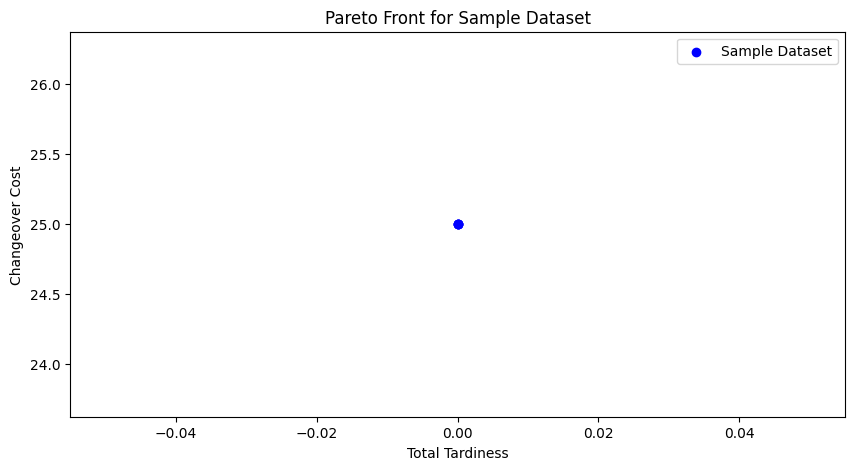

In [80]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate initial population
def generate_initial_population(jobs, population_size):
    population = []
    for _ in range(population_size):
        individual = list(range(len(jobs)))
        random.shuffle(individual)
        population.append(individual)
    return population

# Calculate fitness
def calculate_fitness(schedule, jobs, changeover_costs):
    total_tardiness = 0
    total_changeover_cost = 0
    current_time = 0

    for i in range(len(schedule)):
        job_id = schedule[i]
        due_date, processing_time = jobs[job_id]
        current_time += processing_time
        tardiness = max(0, current_time - due_date)
        total_tardiness += tardiness
        
        if i == 0:
            total_changeover_cost += changeover_costs[0][job_id]
        else:
            previous_job_id = schedule[i - 1]
            total_changeover_cost += changeover_costs[previous_job_id][job_id]
    
    return total_tardiness, total_changeover_cost

# Pareto dominance check
def pareto_dominates(a, b):
    return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

# Crossover
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child1 = [-1] * size
    child1[start:end+1] = parent1[start:end+1]
    fill_index = (end + 1) % size
    for gene in parent2:
        if gene not in child1:
            child1[fill_index] = gene
            fill_index = (fill_index + 1) % size
    return child1

# Mutation
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(individual)-1)
            individual[i], individual[j] = individual[j], individual[i]

# Non-dominated sorting
def non_dominated_sorting(population, fitnesses):
    S = [[] for _ in range(len(population))]
    front = [[]]
    n = [0] * len(population)
    rank = [0] * len(population)

    for p in range(len(population)):
        S[p] = []
        n[p] = 0
        for q in range(len(population)):
            if pareto_dominates(fitnesses[p], fitnesses[q]):
                S[p].append(q)
            elif pareto_dominates(fitnesses[q], fitnesses[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            front[0].append(p)

    i = 0
    while len(front[i]) > 0:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        front.append(Q)
    front.pop(-1)
    return front

# Crowding distance calculation
def calculate_crowding_distance(fitnesses, front):
    distance = [0] * len(fitnesses)
    for i in range(len(fitnesses[0])):
        sorted_fitnesses = sorted(enumerate(fitnesses), key=lambda x: x[1][i])
        distance[sorted_fitnesses[0][0]] = float('inf')
        distance[sorted_fitnesses[-1][0]] = float('inf')
        for j in range(1, len(sorted_fitnesses) - 1):
            distance[sorted_fitnesses[j][0]] += (sorted_fitnesses[j+1][1][i] - sorted_fitnesses[j-1][1][i]) / (max(fitnesses, key=lambda x: x[i])[i] - min(fitnesses, key=lambda x: x[i])[i])
    return distance

# NSGA-II algorithm
def nsga_ii(jobs, changeover_costs, population_size=100, generations=100, crossover_rate=0.8, mutation_rate=0.1):
    population = generate_initial_population(jobs, population_size)
    
    for generation in range(generations):
        # Calculate fitness for each individual
        fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
        
        # Non-dominated sorting
        fronts = non_dominated_sorting(population, fitnesses)
        
        # Calculate crowding distance
        distances = calculate_crowding_distance(fitnesses, fronts)
        
        new_population = []
        for i, front in enumerate(fronts):
            if len(new_population) + len(front) > population_size:
                break
            new_population.extend(front)
        remaining = population_size - len(new_population)
        if remaining > 0:
            sorted_front = sorted(fronts[i], key=lambda x: distances[x], reverse=True)
            new_population.extend(sorted_front[:remaining])
        
        # Generate offspring
        offspring_population = []
        while len(offspring_population) < population_size:
            parents = random.sample(new_population, 2)
            if random.random() < crossover_rate:
                offspring = crossover(population[parents[0]], population[parents[1]])
            else:
                offspring = population[parents[0]][:]  # Copy the parent
            mutate(offspring, mutation_rate)
            offspring_population.append(offspring)
        
        population = new_population + offspring_population
        
        # Ensure all individuals are valid lists of job indices
        population = [ind for ind in (new_population + offspring_population) if isinstance(ind, list) and all(isinstance(x, int) for x in ind)]
        
        # Debugging: Check population structure after generation
        for ind in population:
            if not isinstance(ind, list):
                print(f"Error: Population contains non-list: {ind}")
            elif any(not isinstance(x, int) for x in ind):
                print(f"Error: Population contains list with non-integers: {ind}")
        print(f"Generation {generation} population: {population[:2]}")  # Print first two individuals to verify structure
    
    fitnesses = [calculate_fitness(ind, jobs, changeover_costs) for ind in population]
    pareto_front = non_dominated_sorting(population, fitnesses)[0]
    return [fitnesses[i] for i in pareto_front]

# Sample dataset
sample_jobs = [(120, 30), (150, 45), (210, 60)]
sample_changeover_costs = [
    [0, 10, 20],
    [5, 0, 15],
    [10, 5, 0]
]

# Read and parse datasets
def read_and_parse_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    jobs = []
    changeover_costs = []
    reading_jobs = False
    reading_changeover = False

    for line in lines:
        line = line.strip().replace(',', ' ')
        if line == "@jobs":
            reading_jobs = True
            reading_changeover = False
            continue
        elif line == "@changeover":
            reading_jobs = False
            reading_changeover = True
            continue
        
        if reading_jobs:
            if line != "0 0":  # Skip the reference point
                try:
                    job = tuple(map(int, line.split()))
                    if len(job) == 2:
                        jobs.append(job)
                    else:
                        print(f"Skipping invalid job line: {line}")
                except ValueError:
                    print(f"Skipping invalid job line: {line}")
        elif reading_changeover:
            try:
                changeover_costs.append(list(map(int, line.split())))
            except ValueError:
                print(f"Skipping invalid changeover line: {line}")
    
    return jobs, changeover_costs

# Read datasets
jobs_100_new, changeover_100_new = read_and_parse_dataset('SMTTCC1problem')
jobs_50_new, changeover_50_new = read_and_parse_dataset('SMTTCC2problem')
# Run NSGA-II on both datasets
pareto_front_100 = nsga_ii(jobs_100_new, changeover_100_new)
pareto_front_50 = nsga_ii(jobs_50_new, changeover_50_new)

# Display the Pareto fronts

# Pareto front for 100 jobs
pareto_front_100_df = pd.DataFrame(pareto_front_100, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 100 Jobs:")
print(pareto_front_100_df.head())

# Pareto front for 50 jobs
pareto_front_50_df = pd.DataFrame(pareto_front_50, columns=['Total Tardiness', 'Changeover Cost'])
print("Pareto Front for 50 Jobs:")
print(pareto_front_50_df.head())

# Visualize the Pareto fronts


# Visualize the Pareto fronts

# Plot Pareto Front for 100 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_100_df['Total Tardiness'], pareto_front_100_df['Changeover Cost'], c='blue', label='100 Jobs')
plt.title('Pareto Front for 100 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()

# Plot Pareto Front for 50 Jobs
plt.figure(figsize=(10, 5))
plt.scatter(pareto_front_50_df['Total Tardiness'], pareto_front_50_df['Changeover Cost'], c='red', label='50 Jobs')
plt.title('Pareto Front for 50 Jobs')
plt.xlabel('Total Tardiness')
plt.ylabel('Changeover Cost')
plt.legend()
plt.show()